In [1]:
%pip install qiskit
%pip install qiskit-aer

import qiskit.tools.jupyter
%qiskit_version_table

In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from qiskit import QuantumCircuit, Aer
from qiskit.utils import QuantumInstance
from qiskit import transpile 

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

# VQA Poisson
from vqa_poisson import VQAforPoisson


## Experiments

In [3]:
def create_initial_state(N):
    x = np.linspace(0,1,N)
    y = np.cos(x)
    y = y / np.linalg.norm(y)
    
    return y

def experiment(bc, num_trials, num_qubits_list, num_layers, qins, optimze=False):
    
    print('-----------'+bc+' boundary condition --------------')
    
    data = {'num_qubits':[], 'obj_count':[], 'circ_count':[], 'iter_count':[], 'err':[], 'params':[], 'q_sol':[], 'cl_sol':[]}
    
    for num_qubits in tqdm(num_qubits_list):
        print('-------------------------')
        print('num_qubits:', num_qubits)
        
        # set oracle for f vector
        oracle_f = QuantumCircuit(num_qubits)
        oracle_f.x(num_qubits-1)
        oracle_f.h(oracle_f.qubits)

        # change oracle to cosine function
        # y = create_initial_state(2**num_qubits)
        # init_f = QuantumCircuit(num_qubits)
        # init_f.initialize(y, range(0,num_qubits))

        # Transpile the composed circuit for execution
        # oracle_f = transpile(init_f, optimization_level=3)

    
        # set vqa instance
        vqa = VQAforPoisson(num_qubits, num_layers, bc, oracle_f=oracle_f, qinstance=qins, optimize_shift=optimze)


        obj_counts = []
        circ_counts = []
        iter_counts = []
        err = []
        params = []
        q_sol = []
    
        for seed in range(num_trials):
        
            np.random.seed(seed)
            x0 = list(4*np.pi*np.random.rand(vqa.num_params))
            # converged solution
#             x0 = [6.38264275902757471925497156917117536067962646484375,
# 8.71081760647049208046155399642884731292724609375000,
# 7.20155899228167584169568726792931556701660156250000,
# 6.68731466754961001441870394046418368816375732421875,
# 4.84059748913640675027636461891233921051025390625000,
# 7.01263257532668138338749486138112843036651611328125,
# 4.92084156658383520266397681552916765213012695312500,
# 10.53187877792020721301469166064634919166564941406250,
# 12.54619094133973256077752012060955166816711425781250,
# 4.06856663930137507634299254277721047401428222656250,
# 10.98972975868755419526223704451695084571838378906250,
# 6.50613609320823993442672872333787381649017333984375,
# 7.69234511925862651793295299285091459751129150390625,
# 12.11597323771373879708335152827203273773193359375000,
# 1.17211769677697774660884988406905904412269592285156,
# 0.59477625319328264463791811067494563758373260498047,
# 0.38148111282291702339719563497055787593126296997070,
# 10.88287467856012469269444409292191267013549804687500,
# 10.39659322661944251819932105718180537223815917968750,
# 10.10226310395892568294584634713828563690185546875000,
# 12.42411446427315269147584331221878528594970703125000,
# 9.58981634057271392634902440477162599563598632812500,
# 5.85799763179465493578845780575647950172424316406250,
# 8.96085644821462778963905293494462966918945312500000,
# 1.49836136330958979989702584134647622704505920410156,
# 8.02503514946669405105694750091060996055603027343750,
# 2.67080490488173527552362429560162127017974853515625,
# 12.29937231520662521688791457563638687133789062500000,
# 7.16844938251152452579617602168582379817962646484375,
# 4.87774562533375899420207133516669273376464843750000,
# 3.56258469511675635033043363364413380622863769531250,
# 10.69383531226024963700638181762769818305969238281250,
# 5.77682222434608672045897037605755031108856201171875, 
# 7.40450399561230465650396581622771918773651123046875 ]
            
            print(x0)
            #vqa.print_matrix(x0)
            
            res = vqa.minimize(x0, method='powell', save_logs=True)
            
    
            obj_counts.append(vqa.objective_counts)
            circ_counts.append(vqa.circuit_counts)
            iter_counts.append(len(vqa.objective_count_logs))
            err.append(vqa.get_errors(res['x'])['trace'])
            params.append(res['x'])
            q_sol.append(vqa.get_sol(res['x']).real)
            # vqa.print_matrix(res['x'])
            
            print('trial:', seed, 'Err.:', err[-1])
        
        data['num_qubits'].append(num_qubits)
        data['obj_count'].append(obj_counts)
        data['circ_count'].append(circ_counts)
        data['iter_count'].append(iter_counts)
        data['err'].append(err)
        data['params'].append(params)
        data['q_sol'].append(q_sol)
        data['cl_sol'].append(vqa.get_cl_sol().real)
        
    return data

In [4]:
# create noise model parameterized by pError
noise_model = NoiseModel()
pError = 0.0007
error1q = depolarizing_error(pError, 1)
error2q = depolarizing_error(pError, 2)

noise_model.add_all_qubit_quantum_error(error1q, ['id', 'rz', 'sx', 'u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error2q, ['cx'])
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'sx', 'u3', 'cx', 'u1', 'id', 'rz']
  All-qubits errors: ['id', 'rz', 'sx', 'u1', 'u2', 'u3', 'cx']


In [5]:
t0 = time.time()
# optimizer = 'spsa'
num_layers = 5
num_trials = 1
num_qubits_list = [4]
optimize_shift=True
# create instance with noise here
qins = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=42, noise_model=noise_model)

# bc: Periodic
data_p = experiment('Periodic', num_trials, num_qubits_list, num_layers, qins, optimze=optimize_shift)

C:\Users\jlvmi\AppData\Local\Temp\ipykernel_19712\2986213876.py:8: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qins = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=42, noise_model=noise_model)


-----------Periodic boundary condition --------------


  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------
num_qubits: 4
[6.896593888515826, 8.987334637284528, 7.574547976478632, 6.847204019070697, 5.323803221044644, 8.116544802428407, 5.498883072830878, 11.206350031706826, 12.109743395712375, 4.8184682344975025, 9.949110253214393, 6.646289577666751, 7.1382584801773445, 11.63139039619053, 0.8926654342978345, 1.0948990714191347, 0.2540718754635438, 10.463009560025881, 9.77860612850141, 10.932895093864325, 12.297680778506693, 10.042522697586502, 5.799120696948454, 9.808418904536085, 1.4862802696695647, 8.041484717920905, 1.8014305383688254, 11.871059719510393, 6.557739415592751, 5.210795617590082, 3.324503869815388, 9.729307483553026, 5.73215413049621, 7.143151671267129]


c:\Users\jlvmi\OneDrive\University of Michigan\Academics\12. Fall 2023\QC Research\Examples\Lib\site-packages\scipy\optimize\_minimize.py:560: RuntimeWarning: Method powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


It.: 00001, Obj.: -6.946143e-01
It.: 00002, Obj.: -2.108272e+00
It.: 00003, Obj.: -2.604906e+00
It.: 00004, Obj.: -2.643449e+00
It.: 00005, Obj.: -2.662145e+00
It.: 00006, Obj.: -2.710211e+00
It.: 00007, Obj.: -2.716214e+00
It.: 00008, Obj.: -2.722013e+00
It.: 00009, Obj.: -2.725552e+00
It.: 00010, Obj.: -2.730500e+00
It.: 00011, Obj.: -2.731815e+00
It.: 00012, Obj.: -2.714611e+00
trial: 0 Err.: 0.037063796835104246


C:\Users\jlvmi\AppData\Local\Temp\ipykernel_19712\4294598795.py:94: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  q_sol.append(vqa.get_sol(res['x']).real)


## plots

### distribution of solutions

In [8]:
def global2grid(cl_sol):
    N = len(cl_sol)
    n = int(np.sqrt(N))
    F = np.zeros((n,n))

    for i in range(N):
        xi = int(np.floor(i/n))
        yi = int(i % n)
        F[xi,yi] = cl_sol[i]

    return F

def plot_solution_vectors(q_sol, cl_sol):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(q_sol, label='quantum', color='blue')
    ax.plot(cl_sol, label='classical', color='black', linestyle='dashed')
    ax.legend()
    ax.set_xlabel('Node number')
    ax.set_ylabel('Components of solution')

    cnorm = np.linalg.norm(q_sol)
    qnorm = np.linalg.norm(cl_sol)

    ax.text(0.55, 0.65, 'Norm (quantum) = %.1f'%(qnorm), transform=ax.transAxes)
    ax.text(0.55, 0.55, 'Norm (classical) = %.1f'%(cnorm), transform=ax.transAxes)

    # Save the figure as a PDF
    fig.savefig('solution_vectors.pdf', format='pdf')
    
    return fig, ax

def plot_solution_vectors_2D(q_sol, cl_sol, N):
    
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)

    x, y = np.meshgrid(x, y) 
  
    F = global2grid(q_sol)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(x, y, F) 
    
    return fig, ax

In [14]:
idx1, idx2 = 0, 0
# for i in range(0,len(data_p['params'][0][0])):
#     print('%.50f' % data_p['params'][0][0][i])
data_p['err'][0][0]

0.037063796835104246

Periodic boundary condition, num_qubits: 4
[ 0.45301963  1.12816198  1.67777962  1.97077209  1.98335126  1.72506492
  1.15877648  0.48055245 -0.4999037  -1.17400566 -1.74469377 -2.03887965
 -2.07370644 -1.80841628 -1.2765805  -0.52322544]


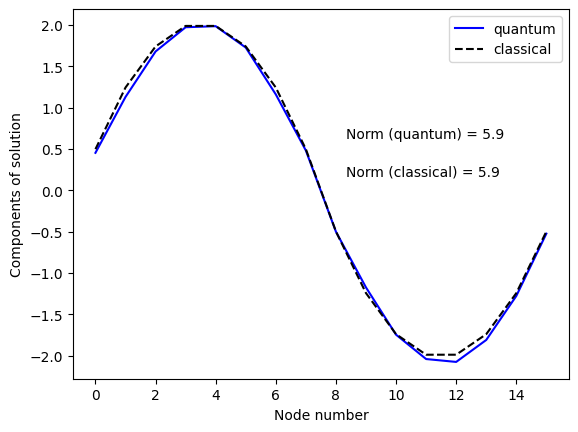

In [9]:
print('Periodic boundary condition, num_qubits:', data_p['num_qubits'][idx1])
q_sol = data_p['q_sol'][idx1][idx2]
cl_sol = data_p['cl_sol'][idx1]
plot_solution_vectors(q_sol, cl_sol)
# plot_solution_vectors_2D(q_sol, cl_sol, 1)
print(q_sol)

In [8]:
print('elapsed time: %.2e'%(time.time() - t0))

elapsed time: 5.50e+02


In [11]:
oracle_f = QuantumCircuit(4)
oracle_f.x(4-1)
oracle_f.h(oracle_f.qubits)
oracle_f.draw(fold=-1)

┌───┐     
q_0: ┤ H ├─────
     ├───┤     
q_1: ┤ H ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤┌───┐
q_3: ┤ X ├┤ H ├
     └───┘└───┘

In [57]:
from qiskit import execute, Aer

f_vec = np.array(execute(oracle_f, Aer.get_backend('statevector_simulator')).result().get_statevector())

In [64]:
def get_A_matrix():
    num_qubits = 4

    I0 = np.array([[1, 0], [0, 0]])
    I = np.array([[1, 0], [0, 1]])
    X = np.array([[0, 1], [1, 0]])

    P = np.zeros((2**num_qubits, 2**num_qubits))
    for i in range(2**num_qubits):
        P[(i+1)%(2**num_qubits), i] = 1

    A0 = I - X
    for i in range(num_qubits-1):
        A0 = np.kron(I, A0)
    A1 = P.T @ A0 @ P

    A = A0 + A1 + (1e-3)*np.eye(2**num_qubits)

    return A

In [65]:
print(np.asmatrix(get_A_matrix()))
print(np.array(f_vec).real)
import scipy

Ainv = np.linalg.inv(get_A_matrix())
s1 = Ainv @ f_vec.real
s2 = scipy.linalg.solve(get_A_matrix(), f_vec.real)
print(s1)
print(s2)

[[ 2.001 -1.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.    -1.   ]
 [-1.     2.001 -1.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.    -1.     2.001 -1.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -1.     2.001 -1.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    -1.     2.001 -1.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -1.     2.001 -1.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.    -1.     2.001 -1.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -1.     2.001 -1.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.    -1.     2.001 -1.
   0.     0.     0.

In [138]:
def plot_solution(cl_sol):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cl_sol, label='classical', color='black', linestyle='dashed')
    ax.legend()
    ax.set_xlabel('Node number')
    ax.set_ylabel('Components of solution')

    cnorm = np.linalg.norm(cl_sol)

    ax.text(0.55, 0.55, 'Norm (classical) = %.1f'%(cnorm), transform=ax.transAxes)
    
    return fig, ax

plot_solution(s1)

NameError: name 's1' is not defined

In [139]:
plot_solution(s2)

NameError: name 's2' is not defined